In [1]:
#загрузка библиотек

import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt  
import seaborn as sns  
import plotly.express as px

# инструменты для построения модели:
from lightfm import LightFM
from lightfm.evaluation import auc_score
from scipy.sparse import coo_matrix, csr_matrix
from sklearn import preprocessing
from lightfm.evaluation import precision_at_k
import datetime

## <span style="color:#1E90FF"> Загрузка данных</span>

In [2]:
data_events = pd.read_csv('data/events.csv')

In [3]:
data_events

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN
...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN
2756097,1438399813142,762376,view,115946,NaN
2756098,1438397820527,1251746,view,78144,NaN
2756099,1438398530703,1184451,view,283392,NaN


In [4]:
data_tree = pd.read_csv('data/category_tree.csv')
data_tree

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0
...,...,...
1664,49,1125.0
1665,1112,630.0
1666,1336,745.0
1667,689,207.0


In [5]:
data_prop_1 = pd.read_csv('data/item_properties_part1.csv')
data_prop_2 = pd.read_csv('data/item_properties_part2.csv')

In [6]:
properties = pd.concat([data_prop_1, data_prop_2])
properties

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513
...,...,...,...,...
9275898,1433646000000,236931,929,n12.000
9275899,1440903600000,455746,6,150169 639134
9275900,1439694000000,347565,686,610834
9275901,1433646000000,287231,867,769062


In [7]:
properties['event_datetime'] = pd.to_datetime(properties['timestamp'], unit = 'ms')

events — датасет с событиями. Колонки:

* timestamp — время события
* visitorid — идентификатор пользователя
* event — тип события
* itemid — идентификатор объекта
* transactionid — идентификатор транзакции, если она проходила

category_tree — файл с деревом категорий (можно восстановить дерево).

* category_id — идентификатор категорий
* parent_id — идентификатор родительской категории

item_properties — файл с свойствами товаров.

* timestamp — момент записи значения свойства
* item_id — идентификатор объекта
* property — свойство
* value — значение свойства

## <span style="color:#1E90FF"> EDA / Анализ и обработка данных</span>

In [8]:
# преобразование временных данных
data_events_dt = data_events.copy()
data_events_dt['timestamp'] = pd.to_datetime(data_events['timestamp'], unit='ms', origin='unix')
data_events_dt.head()

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12.117,257597,view,355908,NaN
1,2015-06-02 05:50:14.164,992329,view,248676,NaN
2,2015-06-02 05:13:19.827,111016,view,318965,NaN
3,2015-06-02 05:12:35.914,483717,view,253185,NaN
4,2015-06-02 05:02:17.106,951259,view,367447,NaN


In [9]:
#преобразование признака времени
data_events_dt['day_of_week'] = data_events_dt['timestamp'].map(lambda x: x.weekday())
data_events_dt['Year'] = data_events_dt['timestamp'].map(lambda x: x.year)
data_events_dt['Month'] = data_events_dt['timestamp'].map(lambda x: x.month)
data_events_dt['Day'] = data_events_dt['timestamp'].map(lambda x: x.day)
data_events_dt['Hour'] = data_events_dt['timestamp'].map(lambda x: x.hour)
data_events_dt['minute'] = data_events_dt['timestamp'].map(lambda x: x.minute)

In [10]:
#разделение времени на периоды 
def get_time_periods(hour):
    if hour >= 3 and hour < 7:
        return 'Dawn'
    elif hour >= 7 and hour < 12:
        return 'Morning'
    elif hour >= 12 and hour < 16:
        return 'Afternoon'
    elif hour >= 16 and hour < 22:
        return 'Evening'
    else:
        return 'Night'
    
data_events_dt['Day Period'] = data_events_dt['Hour'].map(get_time_periods)
data_events_dt['Day Period'].value_counts()

Evening      1078199
Night         765924
Dawn          494588
Afternoon     293490
Morning       123900
Name: Day Period, dtype: int64

In [11]:
data_events_dt

,timestamp,visitorid,event,itemid,transactionid,day_of_week,Year,Month,Day,Hour,minute,Day Period
0,2015-06-02 05:02:12.117,257597,view,355908,NaN,1,2015,6,2,5,2,Dawn
1,2015-06-02 05:50:14.164,992329,view,248676,NaN,1,2015,6,2,5,50,Dawn
2,2015-06-02 05:13:19.827,111016,view,318965,NaN,1,2015,6,2,5,13,Dawn
3,2015-06-02 05:12:35.914,483717,view,253185,NaN,1,2015,6,2,5,12,Dawn
4,2015-06-02 05:02:17.106,951259,view,367447,NaN,1,2015,6,2,5,2,Dawn
...,...,...,...,...,...,...,...,...,...,...,...,...
2756096,2015-08-01 03:13:05.939,591435,view,261427,NaN,5,2015,8,1,3,13,Dawn
2756097,2015-08-01 03:30:13.142,762376,view,115946,NaN,5,2015,8,1,3,30,Dawn
2756098,2015-08-01 02:57:00.527,1251746,view,78144,NaN,5,2015,8,1,2,57,Night
2756099,2015-08-01 03:08:50.703,1184451,view,283392,NaN,5,2015,8,1,3,8,Dawn


In [12]:
#проверка на наличие дупликатов
data_events_dt.duplicated().sum()

460

In [13]:
#удаление дупликатов
data_events_dt = data_events_dt.drop_duplicates()
data_events_dt.duplicated().sum()

0

#### <span style="color:#1E90FF"> Оценка изменений самых популярных товаров во времени </span>
Разделение датасета по времени

In [14]:
#формирование датасета с отсечкой до 1 июля включительно
df_1jun = data_events_dt[data_events_dt['timestamp'] <= '2015-07-01']
df_1jun = df_1jun[df_1jun['event'] == 'transaction']

In [15]:
#формирование ТОП 3 группы товаров проданных за период времени до 1 июля включительно
top = df_1jun.groupby('itemid', as_index=False)['transactionid'].agg('count')
top = top.sort_values(by='transactionid', ascending=False)
top3 = top.head(3)
top3

,itemid,transactionid
1588,119736,36
4954,369447,31
86,7943,30


In [16]:
#формирование датасета с после 1 июля
df_1jul = data_events_dt[data_events_dt['timestamp'] >= '2015-07-02']
df_1jul = df_1jul[df_1jul['event'] == 'transaction']
df_1jul.head(3)

,timestamp,visitorid,event,itemid,transactionid,day_of_week,Year,Month,Day,Hour,minute,Day Period
610656,2015-08-02 05:35:44.445,1318304,transaction,72721,5851.0,6,2015,8,2,5,35,Dawn
611372,2015-08-01 23:42:02.831,1293358,transaction,340794,12729.0,5,2015,8,1,23,42,Night
611382,2015-08-01 23:11:34.133,838490,transaction,235047,7283.0,5,2015,8,1,23,11,Night


In [17]:
#сориторовка количества транзакций по товарам для сравнения 
top = df_1jul.groupby('itemid', as_index=False)['transactionid'].agg('count')
top = top.sort_values(by='transactionid', ascending=False)

In [18]:
#количество транзакций для товара из ТОП 3 до 1 июля
top[top['itemid'] == 369447]

,itemid,transactionid


In [19]:
#количество транзакций для товара из ТОП 3 до 1 июля
top[top['itemid'] == 7943],\
top[top['itemid'] == 119736]

(     itemid  transactionid
 125    7943             16,
       itemid  transactionid
 1925  119736             61)

In [20]:
sum_all = top['transactionid'].sum()
sum_all

12608

In [21]:
#доля товаров из ТОП 3 до 1 июля после 1 июля
77 / sum_all * 100

0.6107233502538071

#### <span style="color:#32CD32"> Вывод:  </span>   
- количество популярных товаров меняется от месяца к месяцу.

#### <span style="color:#1E90FF"> Рассмотрение действий пользователей </span>

In [22]:
#общее описание данных
data_events_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2755641 entries, 0 to 2756100
Data columns (total 12 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  float64       
 5   day_of_week    int64         
 6   Year           int64         
 7   Month          int64         
 8   Day            int64         
 9   Hour           int64         
 10  minute         int64         
 11  Day Period     object        
dtypes: datetime64[ns](1), float64(1), int64(8), object(2)
memory usage: 273.3+ MB


In [23]:
#количество пропусков
null_data = data_events_dt.isnull().sum().sort_values()
print(f'\nСтолбцы с пропусками данных:\n{null_data[null_data > 0]}')


Столбцы с пропусками данных:
transactionid    2733184
dtype: int64


In [24]:
#оценка количества покупок
data_events_dt['event'].value_counts(normalize=True) * 100

view           96.682333
addtocart       2.502721
transaction     0.814947
Name: event, dtype: float64

Text(0, 0.5, 'Количества действий')

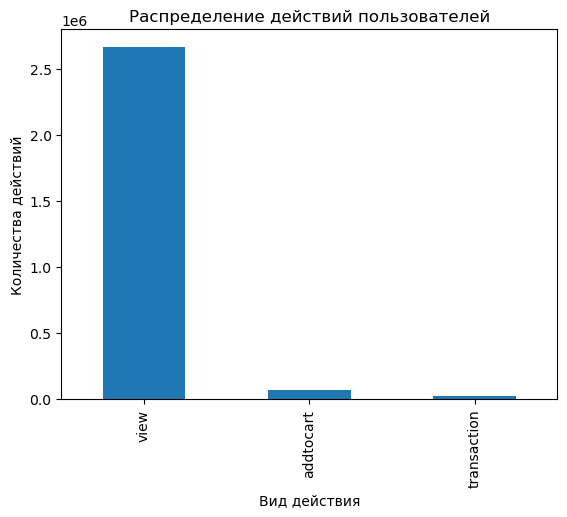

In [25]:
# оценка распределения действий пользователей
ax = data_events_dt['event'].value_counts() \
    .plot(kind='bar', title='Распределение действий пользователей')

ax.set_xlabel('Вид действия')
ax.set_ylabel('Количества действий')

#### <span style="color:#32CD32"> Вывод:  </span> 
- количество покупок среди всех действий пользователей составляет всего 0,81 %. Это объясняет, почему в колонке 'transactionid' такое количество пропусков.

#### <span style="color:#1E90FF"> Оценка распределения количества покупок по датам </span>

In [26]:
data = data_events_dt[data_events_dt['event'] == 'transaction']
data

,timestamp,visitorid,event,itemid,transactionid,day_of_week,Year,Month,Day,Hour,minute,Day Period
130,2015-06-02 05:17:56.276,599528,transaction,356475,4000.0,1,2015,6,2,5,17,Dawn
304,2015-06-01 21:18:20.981,121688,transaction,15335,11117.0,0,2015,6,1,21,18,Evening
418,2015-06-01 21:25:15.008,552148,transaction,81345,5444.0,0,2015,6,1,21,25,Evening
814,2015-06-01 16:38:56.375,102019,transaction,150318,13556.0,0,2015,6,1,16,38,Evening
843,2015-06-01 16:01:58.180,189384,transaction,310791,7244.0,0,2015,6,1,16,1,Evening
...,...,...,...,...,...,...,...,...,...,...,...,...
2755294,2015-07-31 21:12:56.570,1050575,transaction,31640,8354.0,4,2015,7,31,21,12,Evening
2755349,2015-07-31 21:57:58.779,861299,transaction,456602,3643.0,4,2015,7,31,21,57,Evening
2755508,2015-07-31 15:48:50.123,855941,transaction,235771,4385.0,4,2015,7,31,15,48,Afternoon
2755603,2015-07-31 15:12:40.300,548772,transaction,29167,13872.0,4,2015,7,31,15,12,Afternoon


In [27]:
#изменение формата даты для оценки распределения покупок по месяцам
data_date_change = data.copy()
data_date_change['timestamp'] = data['timestamp'].dt.strftime('%Y-%m-%d')
data_date_change

,timestamp,visitorid,event,itemid,transactionid,day_of_week,Year,Month,Day,Hour,minute,Day Period
130,2015-06-02,599528,transaction,356475,4000.0,1,2015,6,2,5,17,Dawn
304,2015-06-01,121688,transaction,15335,11117.0,0,2015,6,1,21,18,Evening
418,2015-06-01,552148,transaction,81345,5444.0,0,2015,6,1,21,25,Evening
814,2015-06-01,102019,transaction,150318,13556.0,0,2015,6,1,16,38,Evening
843,2015-06-01,189384,transaction,310791,7244.0,0,2015,6,1,16,1,Evening
...,...,...,...,...,...,...,...,...,...,...,...,...
2755294,2015-07-31,1050575,transaction,31640,8354.0,4,2015,7,31,21,12,Evening
2755349,2015-07-31,861299,transaction,456602,3643.0,4,2015,7,31,21,57,Evening
2755508,2015-07-31,855941,transaction,235771,4385.0,4,2015,7,31,15,48,Afternoon
2755603,2015-07-31,548772,transaction,29167,13872.0,4,2015,7,31,15,12,Afternoon


In [28]:
#оценка количества покупок по дням
data_show = data_date_change.groupby('timestamp')['transactionid'].agg('count').reset_index().sort_values(by='transactionid')
px.scatter(data_show, x='timestamp', y='transactionid', size_max=20, size='transactionid', color='transactionid')

In [29]:
#оценка среднего чека покупок по дням
data_show = data_date_change.groupby('timestamp')['transactionid'].agg('mean').reset_index().sort_values(by='transactionid')
px.scatter(data_show, x='timestamp', y='transactionid', size_max=20, size='transactionid', color='transactionid')

#### <span style="color:#32CD32"> Выводы:  </span> 
- количество покупок снижается после августа;
- в июле наблюдается просадка по среднему чеку покупок;
- с конца августа снижается средний чек покупок.

In [30]:
data_1K = data_date_change[data_date_change['transactionid'] <= 1000]
data_5K = data_date_change[(data_date_change['transactionid'] > 1000) & (data_date_change['transactionid'] <= 5000)]
data_10K = data_date_change[(data_date_change['transactionid'] > 5000) & (data_date_change['transactionid'] <= 10000)]
data_over_10K = data_date_change[data_date_change['transactionid'] > 10000]

In [31]:
#оценка количества покупок стоимостью до 1000
data_show = data_1K.groupby('timestamp')['transactionid'].agg('count').reset_index().sort_values(by='transactionid')
px.scatter(data_show, x='timestamp', y='transactionid', size_max=20, size='transactionid', color='transactionid')

In [32]:
#оценка количества покупок стоимостью более 1000 и менее 5000
data_show = data_5K.groupby('timestamp')['transactionid'].agg('count').reset_index().sort_values(by='transactionid')
px.scatter(data_show, x='timestamp', y='transactionid', size_max=20, size='transactionid', color='transactionid')

In [33]:
#оценка количества покупок стоимостью более 5000 и менее 10000
data_show = data_10K.groupby('timestamp')['transactionid'].agg('count').reset_index().sort_values(by='transactionid')
px.scatter(data_show, x='timestamp', y='transactionid', size_max=20, size='transactionid', color='transactionid')

In [34]:
#оценка количества покупок стоимостью более 10000
data_show = data_over_10K.groupby('timestamp')['transactionid'].agg('count').reset_index().sort_values(by='transactionid')
px.scatter(data_show, x='timestamp', y='transactionid', size_max=20, size='transactionid', color='transactionid')

#### <span style="color:#32CD32"> Вывод:  </span> 
- существенной разницы в распределении дешевых и дорогих покупок по времени не просматривается.

#### <span style="color:#1E90FF"> Оценка влияния времени суток и дня надели на транзакции </span>

In [35]:
# Транзакции в период времени
data_show = data_date_change.groupby('Day Period')['transactionid'].agg('count').reset_index().sort_values(by='transactionid')
px.scatter(data_show, x='Day Period', y='transactionid', size_max=20, size='transactionid', color='transactionid')

In [36]:
#транзации в день недели
data_show = data_date_change.groupby('day_of_week')['transactionid'].agg('count').reset_index().sort_values(by='transactionid')
px.scatter(data_show, x='day_of_week', y='transactionid', size_max=20, size='transactionid', color='transactionid')

In [37]:
#транзакции от часа дня
data_show = data_date_change.groupby('Hour')['transactionid'].agg('count').reset_index().sort_values(by='transactionid')
px.scatter(data_show, x='Hour', y='transactionid', size_max=20, size='transactionid', color='transactionid')

#### <span style="color:#32CD32"> Выводы:  </span> 
- количество покупок существенно зависит от времени суток, наибольшее количество покупок происходит в период с 17 и до 23 часов;
- на количество покупок влияет день недели, наибольшее количество покупок делают в среду.

In [38]:
#оценка количества самых популярных описаний товаров
properties['property'].value_counts(normalize=True).head(20)

888           0.147979
790           0.088308
available     0.074159
categoryid    0.038874
6             0.031144
283           0.029464
776           0.028320
678           0.023770
364           0.023500
202           0.022141
839           0.020578
917           0.020577
112           0.020569
764           0.020569
159           0.020569
227           0.017138
698           0.014295
451           0.013041
663           0.011877
962           0.011806
Name: property, dtype: float64

In [39]:
top_properties = properties.drop_duplicates(['itemid', 'property']).groupby("property")['itemid'].count().sort_values(ascending=False)[:10]

In [40]:
properties_filtered = properties[properties['property'].isin(set(top_properties.index))]
properties_filtered.shape

(9889797, 5)

In [41]:
properties_filtered.head(10)

,timestamp,itemid,property,value,event_datetime
0,1435460400000,460429,categoryid,1338,2015-06-28 03:00:00
1,1441508400000,206783,888,1116713 960601 n277.200,2015-09-06 03:00:00
3,1431226800000,59481,790,n15360.000,2015-05-10 03:00:00
5,1436065200000,285026,available,0,2015-07-05 03:00:00
10,1439089200000,450113,888,1038400 45956 n504.000,2015-08-09 03:00:00
14,1434250800000,169055,790,n21000.000,2015-06-14 03:00:00
15,1437274800000,186518,available,0,2015-07-19 03:00:00
16,1435460400000,178601,790,n5400.000,2015-06-28 03:00:00
17,1436670000000,319291,888,1292080,2015-07-12 03:00:00
21,1431226800000,344365,159,519769,2015-05-10 03:00:00


#### <span style="color:#1E90FF"> Подготовка и проверка моделей </span>

In [42]:
data_events_dt.head(5)

,timestamp,visitorid,event,itemid,transactionid,day_of_week,Year,Month,Day,Hour,minute,Day Period
0,2015-06-02 05:02:12.117,257597,view,355908,NaN,1,2015,6,2,5,2,Dawn
1,2015-06-02 05:50:14.164,992329,view,248676,NaN,1,2015,6,2,5,50,Dawn
2,2015-06-02 05:13:19.827,111016,view,318965,NaN,1,2015,6,2,5,13,Dawn
3,2015-06-02 05:12:35.914,483717,view,253185,NaN,1,2015,6,2,5,12,Dawn
4,2015-06-02 05:02:17.106,951259,view,367447,NaN,1,2015,6,2,5,2,Dawn


In [43]:
#разбиене датасета по временни
start_date = '2015-5-3'
end_date = '2015-5-18'
events = data_events_dt[(data_events_dt.timestamp >= start_date) & (data_events_dt.timestamp <= end_date)]

In [44]:
#подготовка датасета для обучения и тестирования модели
split_point = int(np.round(events.shape[0]*0.8))
events_train = events.iloc[0:split_point]
events_test = events.iloc[split_point::]
events_test = events_test[(events_test['visitorid'].isin(events_train['visitorid']))
                          & (events_test['itemid'].isin(events_train['itemid']))]

In [45]:
print(events_train.shape)
print(events_test.shape)


(237026, 12)
(8796, 12)


In [46]:
# Закодируем признаки:
id_cols=['visitorid','itemid']
trans_cat_train=dict()
trans_cat_test=dict()

for k in id_cols:
    cate_enc=preprocessing.LabelEncoder()
    trans_cat_train[k]=cate_enc.fit_transform(events_train[k].values)
    trans_cat_test[k]=cate_enc.transform(events_test[k].values)

In [47]:
ratings = dict()

cate_enc=preprocessing.LabelEncoder()
ratings['train'] = cate_enc.fit_transform(events_train.event)
ratings['test'] = cate_enc.transform(events_test.event)

In [48]:
#Создадим матрицу item-users
n_users=len(np.unique(trans_cat_train['visitorid']))
n_items=len(np.unique(trans_cat_train['itemid']))

In [49]:
rate_matrix = dict()

#используем разреженные матрицы
rate_matrix['train'] = csr_matrix((ratings['train'],
                                   (trans_cat_train['visitorid'],
                                    trans_cat_train['itemid'])),
                                  shape=(n_users, n_items)
                                  )

rate_matrix['test'] = csr_matrix((ratings['test'],
                                  (trans_cat_test['visitorid'],
                                   trans_cat_test['itemid'])),
                                 shape=(n_users, n_items)
                                 )

In [50]:
# Используем LightFM для матричной факторизации
model = LightFM(no_components=10, loss='logistic', random_state=42)
model.fit(rate_matrix['train'], epochs=50)


In [51]:
#проверка качества модели
auc_score(model, rate_matrix['test']).mean()

0.79760563

In [52]:
#проверка качества модели
map_at3 = precision_at_k(model, rate_matrix['test'], k=3).mean()
print('Mean Average Precision at 10: {:.5f}'.format(map_at3))

Mean Average Precision at 10: 0.00237


In [53]:
#проверка работы модели по рекомендации
unique_items = np.unique(trans_cat_train['itemid'])
item_ids = np.arange(0, rate_matrix['train'].shape[1])
user_id = 1
list_pred = model.predict(user_id, item_ids)
recomendations_ids = np.argsort(-list_pred)[:10]
recomendations = unique_items[recomendations_ids]
print('Рекомендация для пользователя {}: {}'.format(user_id, recomendations))

Рекомендация для пользователя 1: [54413 49305 43804 29745 54228 64414 14177 19613 13431 22146]


In [54]:
#обучение и проверка  модели ALS
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import mean_average_precision_at_k

model2 = AlternatingLeastSquares(factors=10, random_state=42)
model2.fit(rate_matrix['train'])

/home/alexandr/anaconda3/envs/ptn311env/lib/python3.11/site-packages/implicit/gpu/__init__.py:13: UserWarning:

CUDA extension is built, but disabling GPU support because of 'Cuda Error: CUDA driver version is insufficient for CUDA runtime version (/home/conda/feedstock_root/build_artifacts/implicit_1700594543264/work/./implicit/gpu/utils.h:71)'

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7251145a2ac0>
Traceback (most recent call last):
  File "/home/alexandr/anaconda3/envs/ptn311env/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/alexandr/anaconda3/envs/ptn311env/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/

  0%|          | 0/15 [00:00<?, ?it/s]

In [55]:
#проверка рекомендации модели ALS
user_id = 1
recomendations_ids, scores = model2.recommend(user_id, rate_matrix['train'][user_id])
recomendations = unique_items[recomendations_ids]
print('Recomendations ids: {}'.format(recomendations_ids))
print('Recomendations for user {}: {}'.format(user_id, recomendations))

Recomendations ids: [38196 56425 63988 46317 31754 50963 55761  4316 68460 50480]
Recomendations for user 1: [38196 56425 63988 46317 31754 50963 55761  4316 68460 50480]


In [56]:
map_at3 = mean_average_precision_at_k(model2, rate_matrix['train'], rate_matrix['test'], K=3)
print('Mean Average Precision at 10: {:.5f}'.format(map_at3))

  0%|          | 0/3372 [00:00<?, ?it/s]

Mean Average Precision at 10: 0.00236


In [57]:
from implicit.evaluation import AUC_at_k
AUC_at_k(model2, rate_matrix['train'], rate_matrix['test'], K=100)

  0%|          | 0/3372 [00:00<?, ?it/s]

0.5168319470044076

In [58]:
#настройка параметров модели

model3 = LightFM(no_components=150, learning_rate=0.05, loss='warp', random_state=42)
model3.fit(rate_matrix['train'], epochs=50, num_threads=4, verbose=True)

Epoch: 100%|██████████| 50/50 [00:07<00:00,  6.43it/s]


In [59]:
auc_score(model3, rate_matrix['test']).mean()

0.8633001

In [60]:
map_at3 = precision_at_k(model3, rate_matrix['test'], k=3).mean()
print('Mean Average Precision at 10: {:.5f}'.format(map_at3))

Mean Average Precision at 10: 0.17981


In [61]:
map_at10 = precision_at_k(model3, rate_matrix['test'], k=10).mean()
print('Mean Average Precision at 10: {:.5f}'.format(map_at10))

Mean Average Precision at 10: 0.06554


### Подбор гиперпараметров

In [62]:
import itertools

In [63]:
#сетка для подбора гиперпараметров
def sample_hyperparameters():
    while True:
        yield {
            "no_components": np.random.randint(10, 100),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp", "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(5, 50),
        }

In [64]:
#функция для подбора гиперпараметров
def random_search(train_interactions, test_interactions, num_samples=50, num_threads=1):
    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        num_epochs = hyperparams.pop("num_epochs")

        model = LightFM(**hyperparams)
        model.fit(train_interactions, epochs=num_epochs, num_threads=num_threads)

        score = precision_at_k(model, test_interactions, train_interactions=train_interactions, k=10, num_threads=num_threads).mean()
        
        print(score)

        hyperparams["num_epochs"] = num_epochs

        yield (score, hyperparams, model)

In [65]:
optimized_dict={}

In [66]:
from lightfm import LightFM, cross_validation
from lightfm.evaluation import precision_at_k, auc_score

In [67]:
#разделение датасета для подбора гиперпараметров
train, test = cross_validation.random_train_test_split(rate_matrix['train'], test_percentage=0.25)

In [68]:
train

<125943x68577 sparse matrix of type '<class 'numpy.int64'>'
	with 139449 stored elements in COOrdinate format>

In [ ]:
(score, hyperparams, model) = max(random_search(train_interactions = train, 
                                                test_interactions = test, 
                                                num_threads = 4), key=lambda x: x[0])

0.0033724303
0.0021681776
0.0037041875
0.0009534756
0.0042188033
0.0036362687
0.0023040152
2.0898096e-05
0.0011493954
0.0016091533
0.0026253234
0.0023301376
0.0018729918
0.0032966745
0.0035134924
0.0022987905
0.002264831
0.0046132547
0.0025156084
0.0010292311
0.002688018
0.0037198612
0.0010057208
0.0033854917
0.0008724954
0.0011049869
0.005106972
0.0013113555
0.0021498916
0.0018311956
0.0040333327
0.0019800947
0.0019722579
0.0030641833
0.0032705518
0.0027298138
0.0017632769
0.0012382122
0.0012382122
6.269429e-05
0.0029701418
0.0023667093
0.004537499
0.0017867872
0.0036650037
0.0012147018
7.57556e-05
0.0045845197
0.0024947103
0.0005642486


In [ ]:
print("Best score {} at {}".format(score, hyperparams))

Best score 0.005106972064822912 at {'no_components': 91, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.003442564079526465, 'item_alpha': 1.4033579937355907e-08, 'user_alpha': 1.627682136758003e-08, 'max_sampled': 9, 'num_epochs': 41}


In [ ]:
num_epochs = hyperparams.pop("num_epochs")
model_bp = LightFM(**hyperparams)
model_bp.fit(rate_matrix['train'], epochs = num_epochs, verbose = True)

Epoch: 100%|██████████| 41/41 [00:22<00:00,  1.83it/s]


In [ ]:
#проверка модели с подобранными гиперпараметрами
auc_score(model_bp, rate_matrix['test']).mean()

0.7881211

In [ ]:
#проверка модели с подобранными гиперпараметрами
map_at3 = precision_at_k(model_bp, rate_matrix['test'], k=3).mean()
print('Mean Average Precision at 10: {:.5f}'.format(map_at3))

Mean Average Precision at 10: 0.17843


In [ ]:
optimized_dict['matrix'] = {'score': score, 
                                  'params': hyperparams}

#### <span style="color:#32CD32"> Выводы:  </span> 
- даже после подбора гиперпарметров, наилучший результат показала модель - LightFM(model3) с подобранными параметрами.

### Сохранение матрицы и обученной модели для предитивной модели и Dockerfile

In [70]:
import pickle

In [ ]:
with open('optimized_dict.pkl', 'wb') as f:
    pickle.dump(optimized_dict, f)

In [ ]:
with open('data/model_recom.pkl', 'wb') as output:
    pickle.dump(model3, output)

In [71]:
with open('data/model_recom.pkl', 'rb') as pkl_file:
    model_recom = pickle.load(pkl_file)

In [72]:
unique_items = np.unique(trans_cat_train['itemid'])
item_ids = np.arange(0, rate_matrix['train'].shape[1])
user_id = 5
list_pred = model_recom.predict(user_id, item_ids)
recomendations_ids = np.argsort(-list_pred)[:10]
recomendations = unique_items[recomendations_ids]
print('Рекомендация для пользователя {}: {}'.format(user_id, recomendations))

Рекомендация для пользователя 5: [66386 35767 13431 54228 24341 14908 26438 26367 45915  2108]


In [ ]:
with open('data/unique_items.pkl', 'wb') as output:
    pickle.dump(unique_items, output)

In [ ]:
with open('data/rate_matrix_origin.pkl', 'wb') as output:
    pickle.dump(rate_matrix, output)

In [106]:
with open('data/rate_matrix_all.pkl', 'rb') as pkl_file2:
    rate_matrix_from_file = pickle.load(pkl_file2)


In [108]:
with open('data/rate_matrix.pkl', 'wb') as output:
   pickle.dump(rate_matrix, output)

In [109]:
with open('data/rate_matrix.pkl', 'rb') as pkl_file2:
    rate_matrix = pickle.load(pkl_file2)

In [114]:
unique_items = np.unique(trans_cat_train['itemid'])
item_ids = np.arange(0, rate_matrix['train'].shape[1])
user_id = 31
list_pred = model_recom.predict(user_id, item_ids)
recomendations_ids = np.argsort(-list_pred)[:10]
recomendations = unique_items[recomendations_ids]
print('Рекомендация для пользователя {}: {}'.format(user_id, recomendations))

Рекомендация для пользователя 31: [13950 28991 19663  7219 57847 45159 38251  3411 58330 66024]


In [ ]:
with open('data/unique_items.pkl', 'rb') as pkl_file2:
    unique_items_from_file = pickle.load(pkl_file2)

In [121]:
!python -m pip freeze > requirements_2.txt